In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%matplotlib inline
%config InlineBackend.figure_format = 'png'

In [80]:
train = pd.read_csv('/Users/gauthamsrivatsav/Documents/Internship/Kaggle/House_Price_Prediction/train.csv')
test = pd.read_csv('/Users/gauthamsrivatsav/Documents/Internship/Kaggle/House_Price_Prediction/test.csv')

In [81]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'], test.loc[:,'MSSubClass':'SaleCondition']))
all_data.shape

(2919, 79)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1fe65f10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a208c6e50>]], dtype=object)

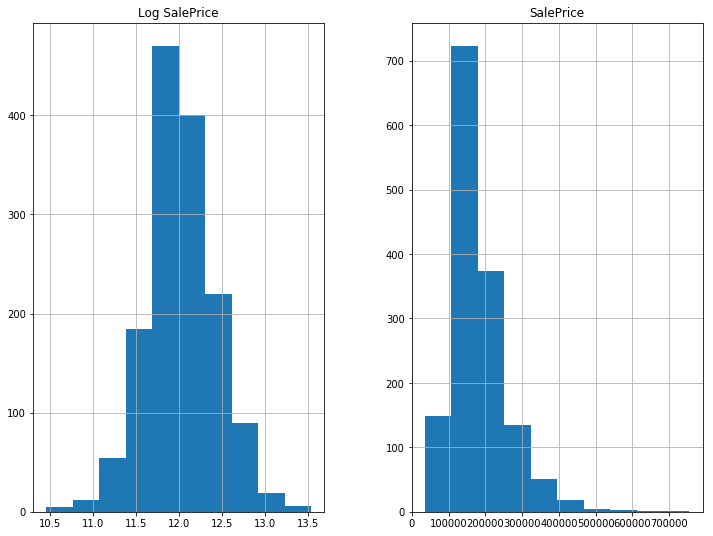

In [83]:
matplotlib.rcParams['figure.figsize'] = (12,9)
prices = pd.DataFrame({'SalePrice':train['SalePrice'], 'Log SalePrice': np.log1p(train['SalePrice'])})
prices.hist()

In [84]:
#Log transform the target

train['SalePrice'] = np.log1p(train['SalePrice'])
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index
train[numeric_feats].head()



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [85]:
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [86]:
all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())
print train.shape
print test.shape
print all_data.shape[0]
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

(1460, 81)
(1459, 80)
2919


In [87]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv (model):
    return np.sqrt(-cross_val_score(model,X_train,y,cv= 5, scoring = 'neg_mean_squared_error'))

In [88]:
model_Ridge = Ridge()
alphas = [0.05,0.1,0.3,1,5,10,15,30,50,75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

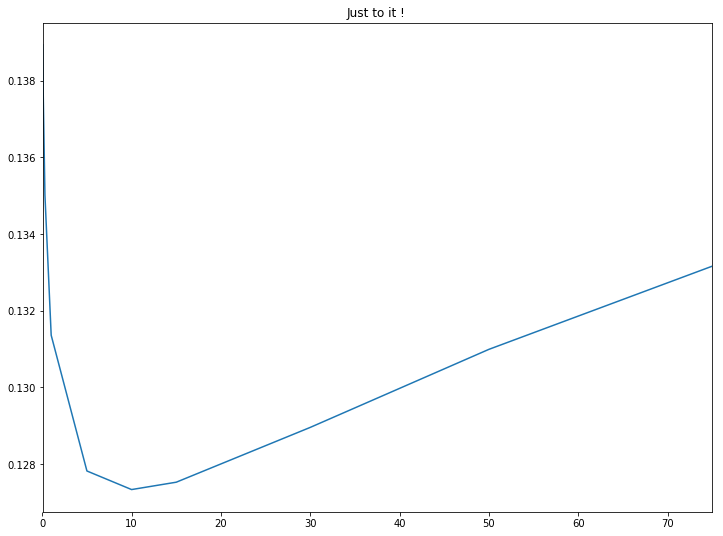

In [89]:
cv_ridge = pd.Series(cv_ridge,index = alphas)
cv_ridge.plot(title = 'Just to it ! ')

In [90]:
cv_ridge.min()

0.1273373466867076

In [91]:
model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005]).fit(X_train, y)

In [92]:
rmse_cv(model_lasso).mean()

0.12314421090977448

In [95]:
coeff_lasso = pd.Series(model_lasso.coef_, index = X_train.columns)

In [97]:
print 'Lasso picked ', str(sum(coeff_lasso != 0)), 'out of ', str(len(coeff_lasso))

 Lasso picked  111 out of  288


In [102]:
imp_coeff = pd.concat([coeff_lasso.sort_values().head(10),coeff_lasso.sort_values().tail(10)])

Text(0.5,1,u'coeffs in Lasso Model')

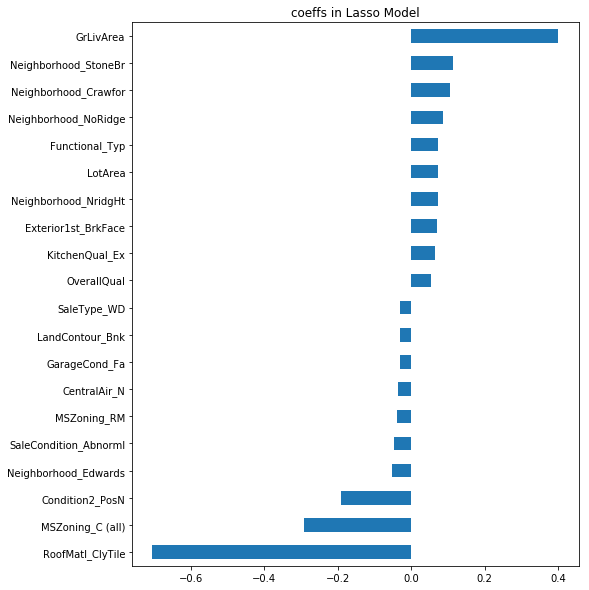

In [103]:
matplotlib.rcParams['figure.figsize'] = (8,10)
imp_coeff.plot(kind = 'barh')
plt.title('coeffs in Lasso Model')

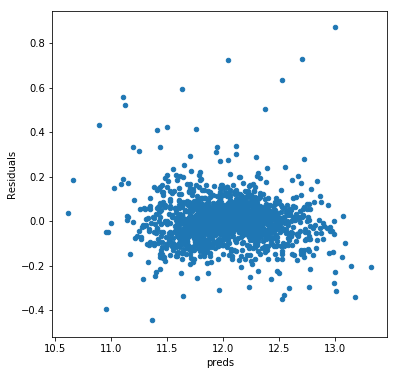

In [110]:
matplotlib.rcParams['figure.figsize'] = (6,6)
preds = pd.DataFrame({"preds": model_lasso.predict(X_train),"true": y})
preds['Residuals'] = preds['preds']-preds['true']
preds.plot(x = 'preds', y = 'Residuals', kind = 'scatter')

In [118]:
import xgboost as xgb 
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)
params = {'max_depth': 2, 'eta':0.1}
model = xgb.cv(params,dtrain,num_boost_round = 500, early_stopping_rounds = 100)

OSError: dlopen(/Users/gauthamsrivatsav/anaconda2/lib/python2.7/site-packages/libxgboostwrapper.so, 6): Symbol not found: __ZNKSt5ctypeIcE13_M_widen_initEv
  Referenced from: /Users/gauthamsrivatsav/anaconda2/lib/python2.7/site-packages/libxgboostwrapper.so
  Expected in: /usr/lib/libstdc++.6.0.9.dylib
 in /Users/gauthamsrivatsav/anaconda2/lib/python2.7/site-packages/libxgboostwrapper.so

In [119]:
lasso_preds = np.expm1(model_lasso.predict(X_test))

In [124]:
solution = pd.DataFrame({"id": test.Id, "SalePrice": lasso_preds})
solution.to_csv("ridge_sol.csv", index = False)